# ArcFace Loss Function

In this notebook, we explore the difference between the softmax (cross-entropy) and ArcFace loss functions.

In [286]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import rc, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
plt.rcParams.update({'pdf.fonttype': 'truetype'})

import platform
print(f'Python {platform.python_version()}')
print("Keras version " + tf.keras.__version__)

Python 3.10.2
Keras version 2.8.0


## Data loading and preparation

We use the standard MNIST dataset that consists of 28x28 images of handwritten digits. The images are labeled based on the digit they represent (10 classes in total).

In [83]:
(x_train, y_train_cat), (x_test, y_test_cat) = mnist.load_data()

x_train = x_train[:, :, :, np.newaxis].astype('float32') / 255
x_test = x_test[:, :, :, np.newaxis].astype('float32') / 255

y_train = keras.utils.to_categorical(y_train_cat, 10)
y_test = keras.utils.to_categorical(y_test_cat, 10)

## ArcFace Loss Layer

In this section, we implement the ArcFace loss as a Keras layer.

In [222]:
class ArcFace(keras.layers.Layer):
    def __init__(self, n_classes=10, s=30.0, m=0.50, regularizer=None, **kwargs):
        super(ArcFace, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)

    def call(self, inputs):
        x, y = inputs
        
        # normalize feature and weights
        x = tf.nn.l2_normalize(x, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        
        # dot product
        logits = x @ W

        # clip logits to prevent zero division when backward
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
        target_logits = tf.cos(theta + self.m)

        logits = logits * (1 - y) + target_logits * y
        
        # feature re-scale
        logits *= self.s
        out = tf.nn.softmax(logits)

        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

## Model training

In this section, we train the same convolutional network using softmax and ArcFace losses. The model is configured to produce 3-dimensional embeddigns for the sake of visualization.

In [ ]:
embedding_layer_name = 'embeddings'
weight_decay = 1e-4

def build_model(loss):
    input_x = Input(shape=(28, 28, 1))
    input_y = Input(shape=(10,))
    
    x = Conv2D(32, (3, 3), activation='relu')(input_x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(3, 
              activation='linear', 
              kernel_initializer='he_normal',
              kernel_regularizer=regularizers.l2(weight_decay), 
              name=embedding_layer_name)(x)
    
    if loss == 'softmax':
        output = Dense(10, activation='softmax')(x)
    elif loss == 'arcface':
        output = ArcFace(n_classes=10, m=0.7, regularizer=regularizers.l2(weight_decay))([x, input_y])
    else: 
        raise Exception(f'Unknown loss function {loss}')

    model = Model([input_x, input_y], output)

    model.compile(
        optimizer=keras.optimizers.Adam(0.002),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'],
    )
    model.fit(
        [x_train, y_train],
        y_train,
        epochs=15,
        batch_size=128,
        validation_data=[[x_test, y_test], y_test]
    )
    
    return model
    
#model_softmax = build_model('softmax')
model_arcface = build_model('arcface')

## Compute and Visualize the Embeddigns

We compute the embeddings for the same test set using both models, normalize the embedding vectors to the unit length, and visualize the results.  

313/313 [==============================] - 1s 2ms/step


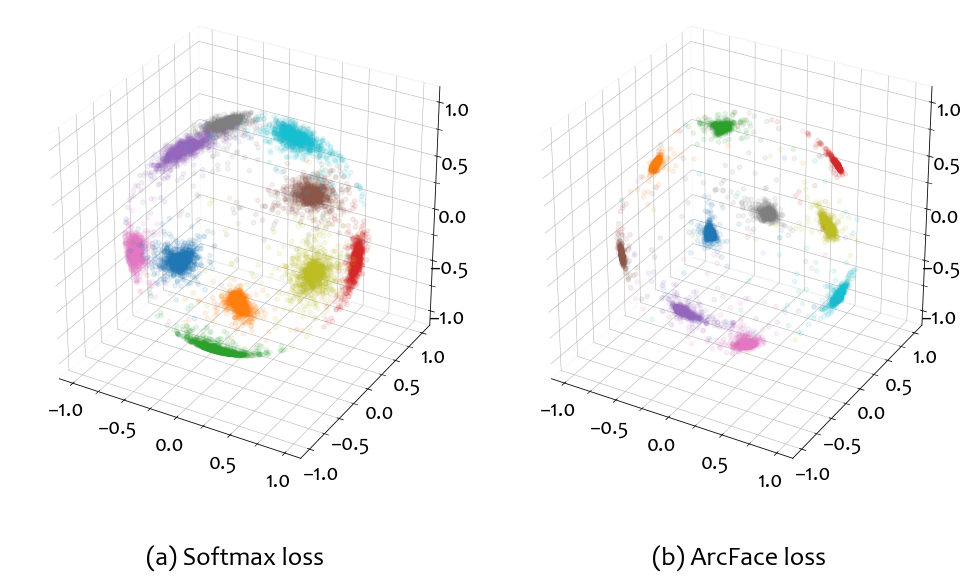

In [319]:
def compute_embeddigns(model):
    model_embeddigns = Model(inputs=model.input, outputs=model.get_layer(embedding_layer_name).output)
    embeddings = model_embeddigns.predict([x_test, y_test], verbose=1)
    embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)
    
    return embeddings

e_softmax = compute_embeddigns(model_softmax)
e_arcface = compute_embeddigns(model_arcface)

def add_embedding_plot(fig, position, e):
    ax = fig.add_subplot(1, 2, position, projection='3d')
    for c in range(len(np.unique(y_test_cat))):
        ax.scatter3D(e[y_test_cat==c, 0], 
                     e[y_test_cat==c, 1], 
                     e[y_test_cat==c, 2], '.', alpha=0.1)
        
    ax.set_box_aspect([1, 1, 1])  # equal aspect ratio
    
    ax.minorticks_on()
        
    ticks_major = [-1, -0.5, 0, 0.5, 1]
    ticks_minor = [-0.75, -0.25, 0.25, 0.75]
    ax.set_xticks(ticks_major)
    ax.set_yticks(ticks_major)
    ax.set_zticks(ticks_major)
    ax.set_xticks(ticks_minor, minor=True)
    ax.set_yticks(ticks_minor, minor=True)
    ax.set_zticks(ticks_minor, minor=True)
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis._axinfo["grid"].update({"linewidth": 0.5})
    ax.yaxis._axinfo["grid"].update({"linewidth": 0.5})
    ax.zaxis._axinfo["grid"].update({"linewidth": 0.5})

    
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Candara'})
    
fig = plt.figure(figsize=(14, 10))
add_embedding_plot(fig, 1, e_softmax)
add_embedding_plot(fig, 2, e_arcface)
plt.tight_layout()

fig.text(.25, .05, '(a) Softmax loss', ha='center', fontsize=26)
fig.text(.75, .05, '(b) ArcFace loss', ha='center', fontsize=26)
plt.savefig('scatter.pdf')